In [164]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [165]:
import h5py
import numpy as np
from astropy.units import deg
from os import path
#from lenstools import GaussianNoiseGenerator, ConvergenceMap
from scipy.ndimage import gaussian_filter
from scipy.stats import skew

Nick proposed I look at Sigma and Skew of maps as a function of smoothing scale. I'll test that out here. 

In [166]:
smooth, noise = 1.0, 0.29
shape_noise = noise/np.sqrt((2.34**2)*30) #sigma_e/sqrt(A*n)
orig_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTraining.hdf5'
grf_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingGRF_smooth_%0.1f_noise_%0.1f.hdf5'%(smooth,noise)
clone_fname = '/scratch/users/swmclau2/clone_maps/UatuFastPMTrainingRobustifyDeepResnetRegAdvWhiteNoise%0.1f_v6.hdf5'%smooth
#clone_fname = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTrainingRobustifyDeepResnetRegAdvGRFNoise1.0.hdf5'

In [167]:
data_mod = lambda x: gaussian_filter(x+np.random.randn(*x.shape)*shape_noise, [0.0, smooth, smooth]) 

In [168]:
cosmo_no =   np.random.randint(0,200) #121, 64
print cosmo_no
smoothing_scales = np.array([0.0, 1.0, 2.0, 4.0, 8.0, 16.0])

62


In [169]:
def get_std_skew(fname, cosmo_no, smoothing_scales, norm = False):
    boxno = 'Box%03d'%cosmo_no    
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()
        print f[boxno]['Y'][0].squeeze()
    X = data_mod(X)
    plt.imshow(X[24])
    plt.show()
    if norm:
        X = (X-X.mean())/X.std()
        
    stds = np.zeros((X.shape[0], smoothing_scales.shape[0]))
    skews = np.zeros((X.shape[0], smoothing_scales.shape[0]))
    for i, scale in enumerate(smoothing_scales):
        if scale>0:
            smooth_X = gaussian_filter(X, sigma = [0.0, scale, scale])
        else:
            smooth_X = X
        
        stds[:,i] = smooth_X.std(axis = (1,2))
        skews[:, i] = skew(smooth_X.reshape((X.shape[0],-1)), axis = 1)
        
    return stds, skews

[ 0.21366   0.740562]


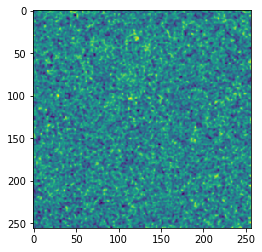

In [170]:
orig_stds, orig_skews = get_std_skew(orig_fname, cosmo_no, smoothing_scales)

[ 0.21366     0.74056202]


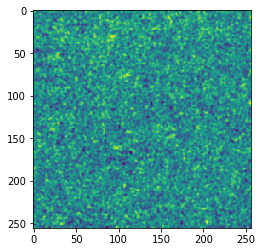

In [171]:
clone_stds, clone_skews = get_std_skew(clone_fname, cosmo_no, smoothing_scales)

[ 0.21366   0.740562]


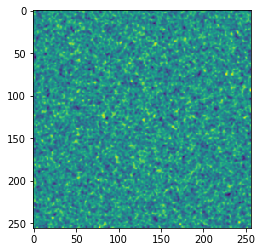

In [172]:
grf_stds, grf_skews = get_std_skew(grf_fname, cosmo_no, smoothing_scales)

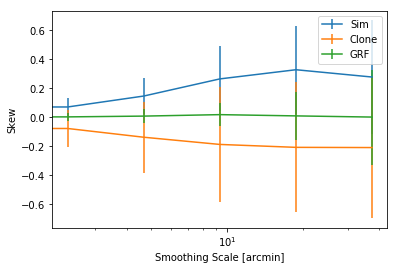

In [173]:
plt.errorbar(smoothing_scales*2.34, orig_skews.mean(axis=0), yerr = orig_skews.std(axis=0), label = 'Sim')
plt.errorbar(smoothing_scales*2.34, -1*clone_skews.mean(axis=0), yerr = clone_skews.std(axis=0), label = 'Clone')
plt.errorbar(smoothing_scales*2.34, grf_skews.mean(axis=0), yerr = grf_skews.std(axis=0), label = 'GRF')
plt.xscale('log')
plt.ylabel('Skew')
plt.xlabel('Smoothing Scale [arcmin]')
plt.legend(loc='best')

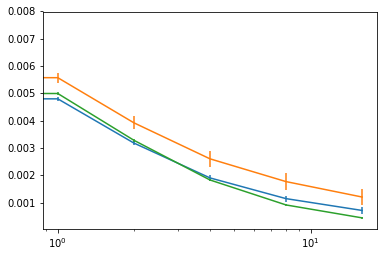

In [174]:
plt.errorbar(smoothing_scales, orig_stds.mean(axis=0), yerr = orig_stds.std(axis=0))
plt.errorbar(smoothing_scales, clone_stds.mean(axis=0), yerr = clone_stds.std(axis=0))
plt.errorbar(smoothing_scales, grf_stds.mean(axis=0), yerr = grf_stds.std(axis=0))
plt.xscale('log')